# Build a Simple RAG Application

In this cookbook, we demonstrate how to build a RAG application and apply a systematic evaluation framework using LangWatch. We'll focus on data-driven approaches to measure and improve retrieval performance.

Traditionally, RAG evaluation emphasizes the quality of the generated answers. However, this approach has major drawbacks: it’s slow (you must wait for the LLM to generate responses), expensive (LLM usage costs add up quickly), and subjective (evaluating answer quality can be inconsistent). Instead, we focus on evaluating retrieval, which is fast, cheap, and objective. 

## Setup

Start by installing the necessary libraries and setting up LangWatch to monitor your RAG application:

In [ ]:
%pip install chromadb langwatch openai llm-data-simulator pandas numpy

In [2]:
import chromadb
import pandas as pd
import openai
import getpass
import langwatch

# Display settings for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define directories
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI and Chroma
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
langwatch.api_key = getpass.getpass('Enter your LangWatch API key: ')
chroma_client = chromadb.PersistentClient()

langwatch.debug = True

## Generating Synthetic Data

In many domains - enterprise tools, legal, finance, internal docs - you don’t start with an evaluation dataset. You don’t have thousands of labeled questions or relevance scores. You barely have users. But you do have access to your own corpus. And with a bit of prompting, you can start generating useful data from it. If you already have a dataset, you can use it directly. If not, you can generate a synthetic dataset using LangWatch’s `data_simulator` library. For retrieval evaluation, your dataset should contain queries and the expected document IDs that should be retrieved. In this example, I downloaded four research papers (GPT-1, GPT-2, GPT-3, GPT-4) and will use `data_simulator` to generate queries based on them.

In [3]:
from data_simulator import DataSimulator

simulator = DataSimulator(api_key=openai.api_key)

# Generate synthetic dataset
results = simulator.generate_from_docs(
    file_paths=[f"{DATA_DIR}/gpt_1.pdf", f"{DATA_DIR}/gpt_2.pdf", f"{DATA_DIR}/gpt_3.pdf", f"{DATA_DIR}/gpt_4.pdf"],
    context="You're an AI research assistant helping researchers understand and analyze academic papers. The researchers need to find specific information, understand methodologies, compare approaches, and extract key findings from these papers.",
    example_queries="what are the main contributions of this paper\nwhat architecture is used in this paper\nexplain the significance of figure X in this paper"
)

Generating answers: 100%|██████████| 203/203 [06:13<00:00,  1.84s/it]


This library allows you to provide a context and example queries, and it will generate a dataset of queries and expected document IDs. Let's take a look at some of the queries it generated:

In [4]:
# Convert to DataFrame for easier analysis
eval_df = pd.DataFrame(results)

# Basic statistics
print(f"\nTotal number of questions: {len(eval_df)}")

# Display some example queries
print("\nExample queries:")
for i, query in enumerate(eval_df['query'].sample(5).values):
    print(f"{i+1}. {query}")


Total number of questions: 203

Example queries:
1. performance metrics of GPT-3 on Winograd and Winogrande datasets
2. describe the traversal-style approach used for input transformations in this paper
3. describe the two-stage training procedure used in this paper
4. details on the fine-tuning hyperparameters and dropout rate used in the model
5. analyze the implications of GPT-4’s performance compared to GPT-3 in generating persuasive content


Notice how the questions even look like they could be from a real user! This is because we provided example queries that resembled user behavior. This is a quick way to get started with evaluating your RAG application. As you start collecting real-world data, you can use provide those as example_queries and generate more useful data. 

## Setting up a Vector Store

Let's use a vector store to store our documents and retrieve them based on user queries. We'll initialize two collections, one with small embeddings and one with large embeddings. This will help us test the performance of our RAG system with different embedding models.

In [27]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize Chroma
client = chromadb.PersistentClient()

# Initialize embeddings
small_embedding = OpenAIEmbeddingFunction(model_name="text-embedding-3-small", api_key=openai.api_key)
large_embedding = OpenAIEmbeddingFunction(model_name="text-embedding-3-large", api_key=openai.api_key)

# Create collections
small_collection = client.get_or_create_collection(name="small", embedding_function=small_embedding)
large_collection = client.get_or_create_collection(name="large", embedding_function=large_embedding)

# Add documents to both collections
for _, row in eval_df.iterrows():
    small_collection.add(
        documents=[row['document']],
        ids=[row['id']],
        metadatas=[{'id': row['id'], 'query': row['query']}]
    )
    large_collection.add(
        documents=[row['document']],
        ids=[row['id']],
        metadatas=[{'id': row['id'], 'query': row['query']}]
    )

print(f"Created collection small with {small_collection.count()} documents.")
print(f"Created collection large with {large_collection.count()} documents.")

Created collection small with 219 documents.
Created collection large with 219 documents.


## Setting up a Retrieval Pipeline

Before setting up a retrieval pipeline, let's understand the key metrics we'll use to evaluate retrieval performance:

**Recall** measures how many of the total relevant items we managed to find. If there are 20 relevant documents in your database but you only retrieve 10 of them, that's 50% recall.

**Mean Reciprocal Rank (MRR)** measures how high the first relevant document appears in your results. If the first relevant document is at position 3, the MRR is 1/3.

In [28]:
def calculate_recall(predictions: list[str], ground_truth: list[str]):
    """Calculate the proportion of relevant items that were retrieved"""
    return len([label for label in ground_truth if label in predictions]) / len(ground_truth)

def calculate_mrr(predictions: list[str], ground_truth: list[str]):
    """Calculate Mean Reciprocal Rank - how high the relevant items appear in results"""
    mrr = 0
    for label in ground_truth:
        if label in predictions:
            # Find the position of the first relevant item
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr

If you retrieve a large number of documents (e.g., 100) and only a few are relevant, you have **high recall but low precision** — forcing the LLM to sift through noise. If you retrieve very few documents and miss many relevant ones, you have **high precision but low recall** — limiting the LLM’s ability to generate good answers. Assuming LLMs improve at selecting relevant information, recall becomes more and more important. That's why most practitioners focus on optimizing recall. MRR is helpful when displaying citations to users. If citation quality isn’t critical for your app, focusing on precision and recall is often enough.

Let's set up 2 functions: one for retrieving documents and another for evaluating the retrieval. We'll use LangWatch to make it easy to track the performance of our retrieval system.

In [29]:
import pandas as pd
import langwatch

# Define a simple retrieval function with LangWatch tracing
@langwatch.span(type="rag")
def retrieve(query, collection, k=5):
    """Retrieve documents from a collection based on a query"""
    results = collection.query(query_texts=[query], n_results=k)
    
    # Get the document IDs from the results
    retrieved_ids = results['ids'][0]
    
    # Log the retrieved documents in LangWatch
    langwatch.get_current_span().update(contexts=[
        {"id": doc_id, "content": doc} 
        for doc_id, doc in zip(retrieved_ids, results['documents'][0])
    ])
    
    return retrieved_ids

# Evaluation function
@langwatch.span(type="evaluation")
def evaluate_retrieval(retrieved_ids, expected_ids):
    """Evaluate retrieval performance using recall and MRR"""
    recall = calculate_recall(retrieved_ids, expected_ids)
    mrr = calculate_mrr(retrieved_ids, expected_ids)
    
    # Log metrics to LangWatch
    langwatch.get_current_span().add_evaluation(
        name="recall",
        score=recall,
        details=f"Recall: {recall:.4f}"
    )
    
    langwatch.get_current_span().add_evaluation(
        name="mrr",
        score=mrr,
        details=f"MRR: {mrr:.4f}"
    )
    
    return {"recall": recall, "mrr": mrr}

Now let's set up our retrieval pipeline. The key to running quick experiments is to parametrize the retrieval pipeline. This makes it easy to swap different retrieval methods as your RAG system evolves. In this example, we’ll compare a small and large embedding model based on recall and MRR. We’ll also vary the number of retrieved documents (k) to see how performance changes.

In [ ]:
# Main evaluation function
def run_evaluation(k_values=[1, 3, 5, 10]):
    """Run evaluation across different k values and embedding models"""
    results = []
    
    # Sample a subset of queries for evaluation
    eval_sample = eval_df.sample(min(50, len(eval_df)))
    
    for k in k_values:
        for model_name, collection in [("small", small_collection), ("large", large_collection)]:
            
            model_results = []
            for _, row in eval_sample.iterrows():
                query = row['query']
                expected_ids = [row['id']]  # The document ID that should be retrieved
                
                with langwatch.trace():
                    # Update trace with query
                    langwatch.get_current_trace().update(input=query)
                    # Update trace metadata
                    langwatch.get_current_trace().update(
                        metadata={"model": model_name, "k": k}
                    )
                    
                    # Retrieve documents
                    retrieved_ids = retrieve(query, collection, k)
                    
                    # Evaluate retrieval
                    metrics = evaluate_retrieval(retrieved_ids, expected_ids)
                
                model_results.append({
                    "query": query,
                    "model": model_name,
                    "k": k,
                    "recall": metrics["recall"],
                    "mrr": metrics["mrr"]
                })
            
            # Calculate average metrics
            avg_recall = sum(r["recall"] for r in model_results) / len(model_results)
            avg_mrr = sum(r["mrr"] for r in model_results) / len(model_results)
            
            results.append({
                "model": model_name,
                "k": k,
                "avg_recall": avg_recall,
                "avg_mrr": avg_mrr
            })
            
            print(f"Model: {model_name}, k={k}, Recall={avg_recall:.4f}, MRR={avg_mrr:.4f}")
    
    return pd.DataFrame(results)
    
# Run the evaluation
results_df = run_evaluation()

Cool. Let's visualize the results: 

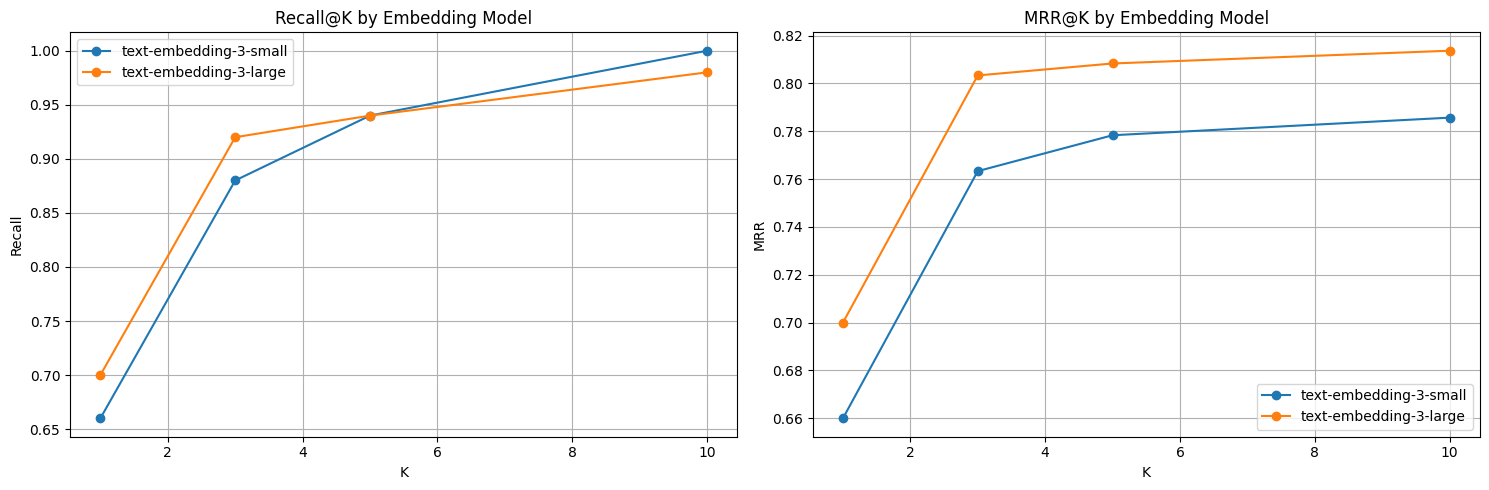


Best configuration for recall: text-embedding-3-small with k=10
Recall: 1.0000, MRR: 0.7857


In [34]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Recall@K
for model in ["small", "large"]:
    model_data = results_df[results_df["model"] == model]
    ax1.plot(model_data["k"], model_data["avg_recall"], marker="o", label=f"text-embedding-3-{model}")

ax1.set_title("Recall@K by Embedding Model")
ax1.set_xlabel("K")
ax1.set_ylabel("Recall")
ax1.legend()
ax1.grid(True)

# Plot MRR@K
for model in ["small", "large"]:
    model_data = results_df[results_df["model"] == model]
    ax2.plot(model_data["k"], model_data["avg_mrr"], marker="o", label=f"text-embedding-3-{model}")

ax2.set_title("MRR@K by Embedding Model")
ax2.set_xlabel("K")
ax2.set_ylabel("MRR")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig("embedding_comparison.png")
plt.show()

# Print the best configuration
best_recall = results_df.loc[results_df["avg_recall"].idxmax()]
print(f"\nBest configuration for recall: text-embedding-3-{best_recall['model']} with k={best_recall['k']}")
print(f"Recall: {best_recall['avg_recall']:.4f}, MRR: {best_recall['avg_mrr']:.4f}")

We can see that the best configuration for recall is the small embedding model with k=10. This is surprising, as we would expect the large embedding model to perform better. Although, if we cared a lot more about citations, the large embedding model might be preferred. 

## Conclusion

Based on our evaluation results, we can now make data-driven decisions about our RAG system. We found that for our usecase, a small embedding model actually provided better performance than a large embedding model. Since there's many different parameters you can change to optimize your RAG pipeline, you want to run a lot more experiments with different configurations, i.e. adding a reranker or using a different retrieval method, like hybrid search. 

Remember that these results are specific to our test dataset - your evaluations may yield different insights. In the next notebook, we'll explore evaluating fine-tuning approaches to embedding models (and why you (almost) always should).